# Project

### Introduction

Content:

- Context / intro -> table of content, distortion, nb of sources, impairments, test parameters
- Subjective QA -> MOS/CI, significance (ANOVA, post-hoc), SI/TI
- Objective QA -> Choosing metrics (e.g. not ssim, LP/PS, VIF, VMAF, ...)

### imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import pandas as pd
import cv2 as cv

from config import DATA_PATH, VIDEOS_PATH

### Pretreatment of the data

In [2]:
file_path = DATA_PATH + "IRCCyN_IVC_DIBR_Videos_Scores.xls"

df_base= pd.read_excel(file_path, skiprows=[0])
nb = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
df_cleaned = df_base.drop(columns=nb)
df_videos = df_cleaned.drop(columns=['Unnamed: 33', 'std'])
df_videos = df_videos.rename(columns={'Unnamed: 0': 'Video'})
df_videos.head()

,Video,MOS,CI
0,Fehn_c_Book_arrival_bh_8_to_10,2.21875,0.270256
1,Fehn_c_Book_arrival_bh_10_to_8,2.15625,0.301427
2,Fehn_c_Book_arrival_sh_8_to_9,3.40625,0.298299
3,Fehn_c_Book_arrival_sh_10_to_9,3.56250,0.258958
4,Fehn_i_Book_arrival_bh_8_to_10,2.03125,0.280474


In [3]:
# Adding video path by matching the MOS columns
df_base_DMOS = pd.read_excel(file_path, sheet_name='DMOS', skiprows=[0])
df_cleaned_DMOS = df_base_DMOS[['Unnamed: 0', 'MOS']]
df_cleaned_DMOS = df_cleaned_DMOS.rename(columns={'Unnamed: 0': 'Video_path'})

if (df_cleaned_DMOS['MOS'].values == df_videos['MOS'].values).all():
    df_videos['Video_path'] = df_cleaned_DMOS['Video_path'].values
    df_videos[['Video', 'Video_path', 'MOS']].head()
else:
    print("Les colonnes MOS ne correspondent pas!")


In [4]:
#divide the video column into two columns: one for the aldorithm (first part of the title) and one for the video ID (Book_arrival, Lovebird1 or Newspaper)
df_videos["Algo"] = pd.Series(dtype='object')
df_videos["Video_ID"] = pd.Series(dtype='object')
for index, row in df_videos.iterrows():
    video_name = row["Video"]
    #check whether there is Book_arrival, Lovebird1 or Newspaper in the video name
    if "Book_arrival" in video_name or "book_arrival" in video_name:
        df_videos.at[index, "Video_ID"] = "Book_arrival"
    elif "Lovebird1" in video_name or "lovebird1" in video_name or 'lovebird' in video_name:
        df_videos.at[index, "Video_ID"] = "Lovebird1"
    elif "Newspaper" in video_name or "newspaper" in video_name:
        df_videos.at[index, "Video_ID"] = "Newspaper"

    if "Fehn_c" in video_name:
        df_videos.at[index, "Algo"] = "Fehn_c"
    elif "Fehn_i" in video_name:
        df_videos.at[index, "Algo"] = "Fehn_i"
    elif "Holes" in video_name:
        df_videos.at[index, "Algo"] = "Holes"
    elif "ICIP_TMM" in video_name:
        df_videos.at[index, "Algo"] = "ICIP_TMM"
    elif "ICME" in video_name:
        df_videos.at[index, "Algo"] = "ICME"
    elif "MPEG" in video_name:
        df_videos.at[index, "Algo"] = "MPEG"
    elif "Muller" in video_name:
        df_videos.at[index, "Algo"] = "Muller"
    else : 
        df_videos.at[index, "Algo"] = "Original"
    

In [5]:
df_videos.head()

,Video,MOS,CI,Video_path,Algo,Video_ID
0,Fehn_c_Book_arrival_bh_8_to_10,2.21875,0.270256,Book_arrival_A1_8_to_10.avi,Fehn_c,Book_arrival
1,Fehn_c_Book_arrival_bh_10_to_8,2.15625,0.301427,Book_arrival_A1_10_to_8.avi,Fehn_c,Book_arrival
2,Fehn_c_Book_arrival_sh_8_to_9,3.40625,0.298299,Book_arrival_A1_8_to_9.avi,Fehn_c,Book_arrival
3,Fehn_c_Book_arrival_sh_10_to_9,3.56250,0.258958,Book_arrival_A1_10_to_9.avi,Fehn_c,Book_arrival
4,Fehn_i_Book_arrival_bh_8_to_10,2.03125,0.280474,Book_arrival_A2_8_to_10.avi,Fehn_i,Book_arrival


### Statistical analysis of MOS and CI

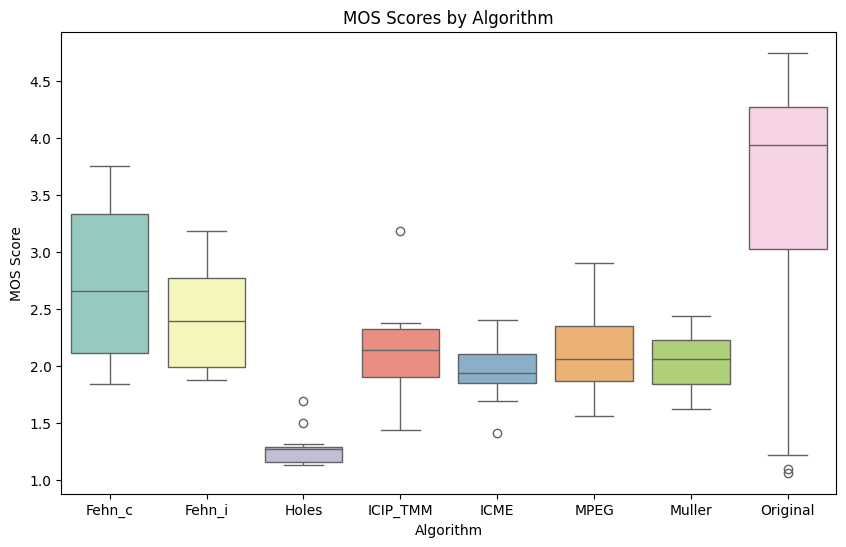

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x="Algo", y="MOS", data=df_videos, hue="Algo", palette="Set3", legend=False)
plt.title("MOS Scores by Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("MOS Score")
plt.show()

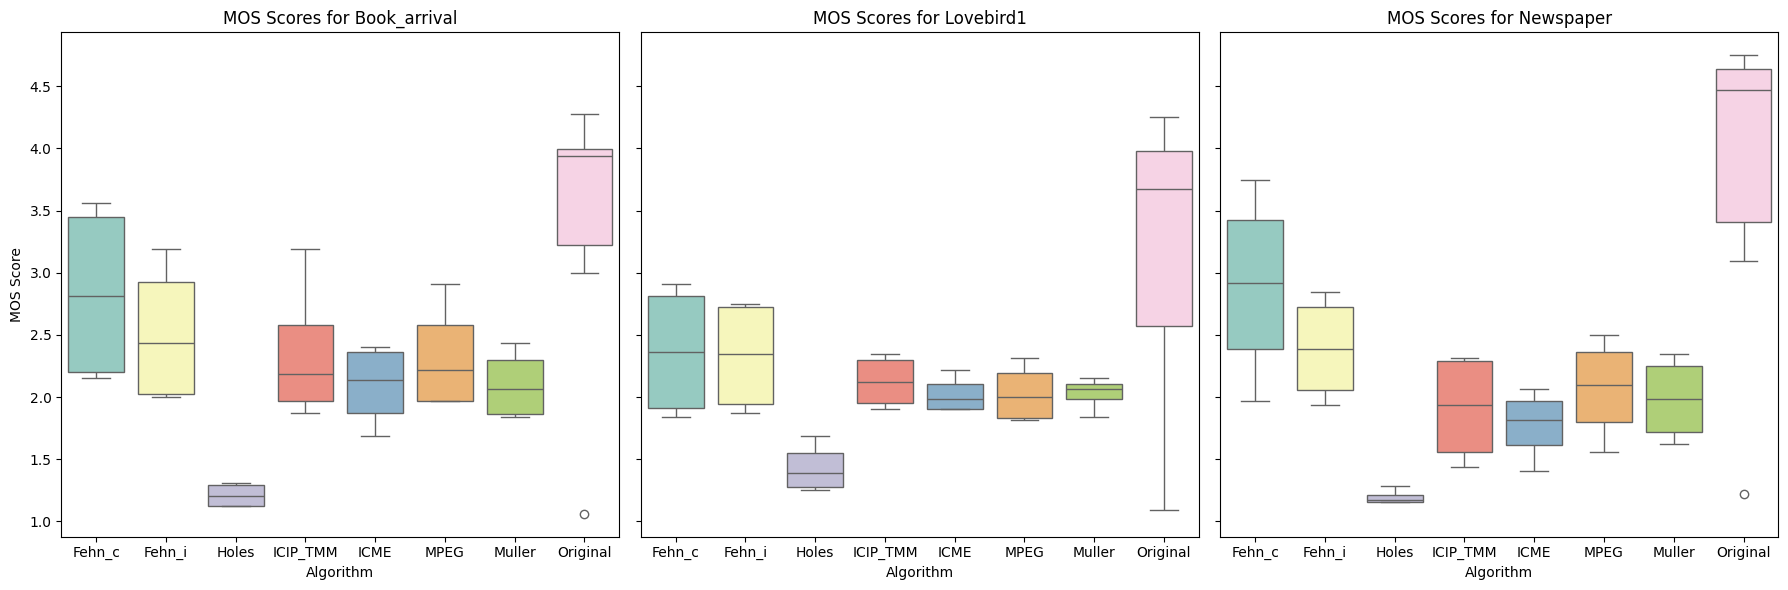

In [ ]:
#do the same but for each video_id and put them in a subplot all aligned horizontally
video_ids = df_videos["Video_ID"].unique()
fig, axes = plt.subplots(1, len(video_ids), figsize=(18,6), sharey=True)
for i, video_id in enumerate(video_ids):
    ax = axes[i]
    subset = df_videos[df_videos["Video_ID"] == video_id]
    sns.boxplot(x="Algo", y="MOS", data=subset, hue="Algo", palette="Set3", ax=ax, legend=False)
    ax.set_title(f"MOS Scores for {video_id}")
    ax.set_xlabel("Algorithm")
    if i == 0:
        ax.set_ylabel("MOS Score")
    else:
        ax.set_ylabel("")
plt.tight_layout()
plt.show()

In [ ]:
# Display MOS and CI from dataframe
print("Algorithm\t\tMean MOS ± CI")
print("-" * 50)
for algo in sorted(df_videos['Algo'].unique()):
    subset = df_videos[df_videos['Algo'] == algo]
    mean_mos = subset['MOS'].mean()
    mean_ci = subset['CI'].mean()
    print(f"{algo:15s}\t{mean_mos:.3f} ± {mean_ci:.3f}  [{mean_mos-mean_ci:.3f}, {mean_mos+mean_ci:.3f}]")

Algorithm		Mean MOS ± CI
--------------------------------------------------
Fehn_c         	2.698 ± 0.282  [2.415, 2.980]
Fehn_i         	2.411 ± 0.263  [2.149, 2.674]
Holes          	1.279 ± 0.159  [1.120, 1.438]
ICIP_TMM       	2.130 ± 0.215  [1.915, 2.346]
ICME           	1.964 ± 0.223  [1.741, 2.186]
MPEG           	2.141 ± 0.225  [1.916, 2.366]
Muller         	2.039 ± 0.222  [1.817, 2.261]
Original       	3.436 ± 0.246  [3.190, 3.681]


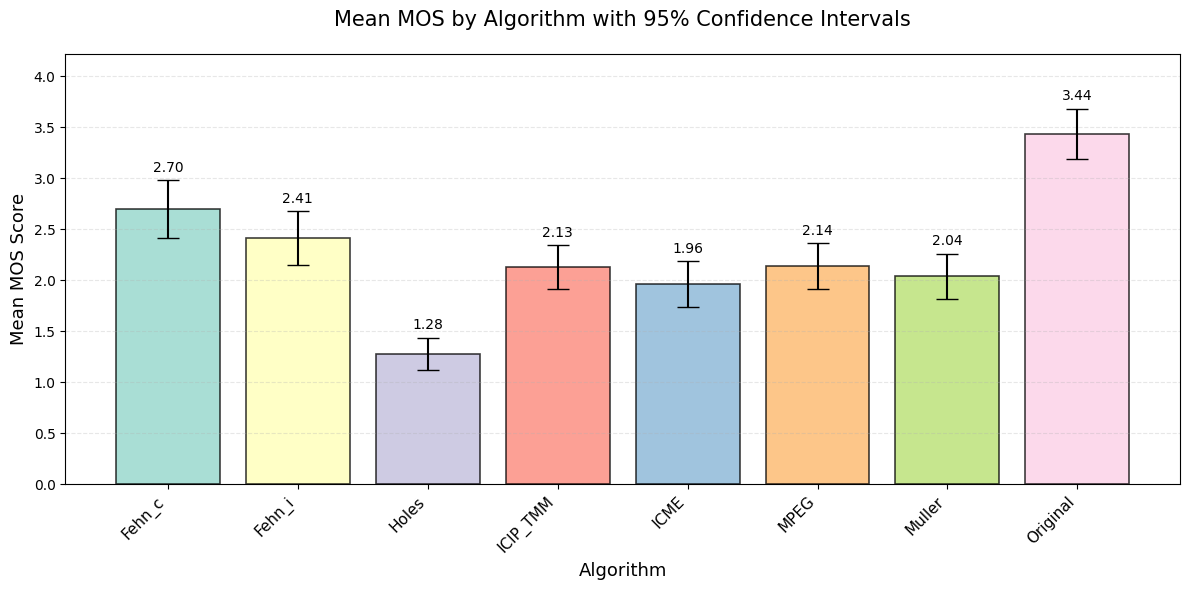

Non-overlapping CIs suggest statistically significant differences


In [ ]:
# Visualization of Mean MOS with CI from dataframe
fig, ax = plt.subplots(figsize=(12, 6))

# Get means and CIs from dataframe
algos = sorted(df_videos['Algo'].unique())
means = []
cis = []

for algo in algos:
    subset = df_videos[df_videos['Algo'] == algo]
    means.append(subset['MOS'].mean())
    cis.append(subset['CI'].mean())

# Create bar plot with error bars
x_pos = np.arange(len(algos))
bars = ax.bar(x_pos, means, yerr=cis, capsize=8, alpha=0.75, 
               color=sns.color_palette("Set3", len(algos)), 
               edgecolor='black', linewidth=1.2)

# Add value labels on bars
for i, (m, c) in enumerate(zip(means, cis)):
    ax.text(i, m + c + 0.05, f'{m:.2f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Algorithm', fontsize=13)
ax.set_ylabel('Mean MOS Score', fontsize=13)
ax.set_title('Mean MOS by Algorithm with 95% Confidence Intervals', fontsize=15, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(algos, rotation=45, ha='right', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(means) + max(cis) + 0.5)

plt.tight_layout()
plt.show()


print("Non-overlapping CIs suggest statistically significant differences")

### Anova

In [ ]:
# Statistical comparison: ANOVA test to check if there are significant differences between algorithms
from scipy.stats import f_oneway

# Prepare data for ANOVA
algo_groups = [group['MOS'].values for name, group in df_videos.groupby('Algo')]

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(*algo_groups)

print(f"One-Way ANOVA Results:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("\nConclusion: There are statistically significant differences between algorithms (p < 0.05)")
else:
    print("\nConclusion: No statistically significant differences between algorithms (p >= 0.05)")

One-Way ANOVA Results:
F-statistic: 13.9396
P-value: 2.8475929891220266e-12

Conclusion: There are statistically significant differences between algorithms (p < 0.05)


### SI/TI

**SI/TI analysis would be very interesting for your video quality data because:**

1. **Content Characterization**: SI/TI objectively characterizes video complexity
   - **SI (Spatial Information)**: Measures spatial detail/texture (edges, patterns)
   - **TI (Temporal Information)**: Measures motion/temporal changes

2. **Algorithm Performance Analysis**: Different DIBR algorithms may perform differently based on content complexity:
   - High SI (detailed scenes) may be more challenging for some algorithms
   - High TI (fast motion) may affect quality differently across algorithms
   
3. **Correlation with MOS**: You can analyze if:
   - Videos with higher SI/TI have lower MOS scores
   - Certain algorithms are more sensitive to SI/TI
   - There's an interaction between content complexity and algorithm performance

4. **Scientific Insight**: Helps explain **why** certain algorithms perform better/worse on specific videos

What You Can Discover

- Which algorithm is most robust to high spatial complexity?
- Which algorithm handles motion (TI) best?
- Is the "Original" video's quality advantage consistent across different SI/TI levels?
- Do confidence intervals vary with content complexity?

#### SI/TI computation

In [8]:
def calculate_SI(frame):
    """
    Calculate Spatial Information (SI) for a frame.
    SI measures the spatial complexity/detail in the frame.
    
    SI = std(Sobel(frame))
    Higher SI = more spatial detail/edges
    """
    # Convert to grayscale if needed
    if len(frame.shape) == 3:
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    else:
        gray = frame
    
    # Apply Sobel operator to detect edges
    sobel_x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=3)
    sobel_y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # SI is the standard deviation of the Sobel filtered frame
    si = np.std(sobel)
    return si

def calculate_TI(frame1, frame2):
    """
    Calculate Temporal Information (TI) between two consecutive frames.
    TI measures the amount of motion/change between frames.
    
    TI = std(frame_diff)
    Higher TI = more motion/temporal change
    """
    # Convert to grayscale if needed
    if len(frame1.shape) == 3:
        gray1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    else:
        gray1 = frame1
        gray2 = frame2
    
    # Calculate frame difference
    diff = gray2.astype(np.float64) - gray1.astype(np.float64)
    
    # TI is the standard deviation of the frame difference
    ti = np.std(diff)
    return ti

def analyze_video_SI_TI(video_path, max_frames=300):
    """
    Analyze a video and return its SI and TI values.
    
    Parameters:
    - video_path: path to video file
    - max_frames: maximum number of frames to analyze (for efficiency)
    
    Returns:
    - mean_si: average SI across frames
    - max_si: maximum SI value
    - mean_ti: average TI across frame pairs
    - max_ti: maximum TI value
    """
    cap = cv.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return None, None, None, None
    
    si_values = []
    ti_values = []
    prev_frame = None
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret or frame_count >= max_frames:
            break
        
        # Calculate SI for current frame
        si = calculate_SI(frame)
        si_values.append(si)
        
        # Calculate TI if we have a previous frame
        if prev_frame is not None:
            ti = calculate_TI(prev_frame, frame)
            ti_values.append(ti)
        
        prev_frame = frame.copy()
        frame_count += 1
    
    cap.release()
    
    mean_si = np.mean(si_values) if si_values else 0
    max_si = np.max(si_values) if si_values else 0
    mean_ti = np.mean(ti_values) if ti_values else 0
    max_ti = np.max(ti_values) if ti_values else 0
    
    return mean_si, max_si, mean_ti, max_ti

In [9]:
# Calculate SI/TI for all videos in the dataset
df_videos['SI_mean'] = 0.0
df_videos['SI_max'] = 0.0
df_videos['TI_mean'] = 0.0
df_videos['TI_max'] = 0.0

print("Calculating SI/TI for all videos...")
print("This may take a few minutes...\n")

for index, row in df_videos.iterrows():
    video_name = row['Video_path']
    video_path = os.path.join(VIDEOS_PATH, video_name)
    print(f"Video path: {video_path}")  
    
    if os.path.exists(video_path):
        print(f"Processing: {video_name[:50]}...")
        si_mean, si_max, ti_mean, ti_max = analyze_video_SI_TI(video_path)
        
        df_videos.at[index, 'SI_mean'] = si_mean
        df_videos.at[index, 'SI_max'] = si_max
        df_videos.at[index, 'TI_mean'] = ti_mean
        df_videos.at[index, 'TI_max'] = ti_max
    else:
        print(f"Video not found: {video_path}")

print("\nSI/TI calculation complete!")
print("\nSample results:")
print(df_videos[['Video_path', 'Algo', 'MOS', 'SI_mean', 'TI_mean']].head(10))

Calculating SI/TI for all videos...
This may take a few minutes...

Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A1_8_to_10.avi
Processing: Book_arrival_A1_8_to_10.avi...
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A1_10_to_8.avi
Processing: Book_arrival_A1_10_to_8.avi...
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A1_8_to_9.avi
Processing: Book_arrival_A1_8_to_9.avi...
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A1_10_to_9.avi
Processing: Book_arrival_A1_10_to_9.avi...
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A2_8_to_10.avi
Processing: Book_arrival_A2_8_to_10.avi...
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A2_10_to_8.avi
Processing: Book_arrival_A2_10_to_8.avi...
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A2_8_to_9.avi
Processing: Book_arrival_A2_8_to_9.avi...
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A2_10_to_9.avi
Processing: Book_arrival_A2_10_to_9.avi...
Video path: IRCCyN_IVC_DIBR_Vide

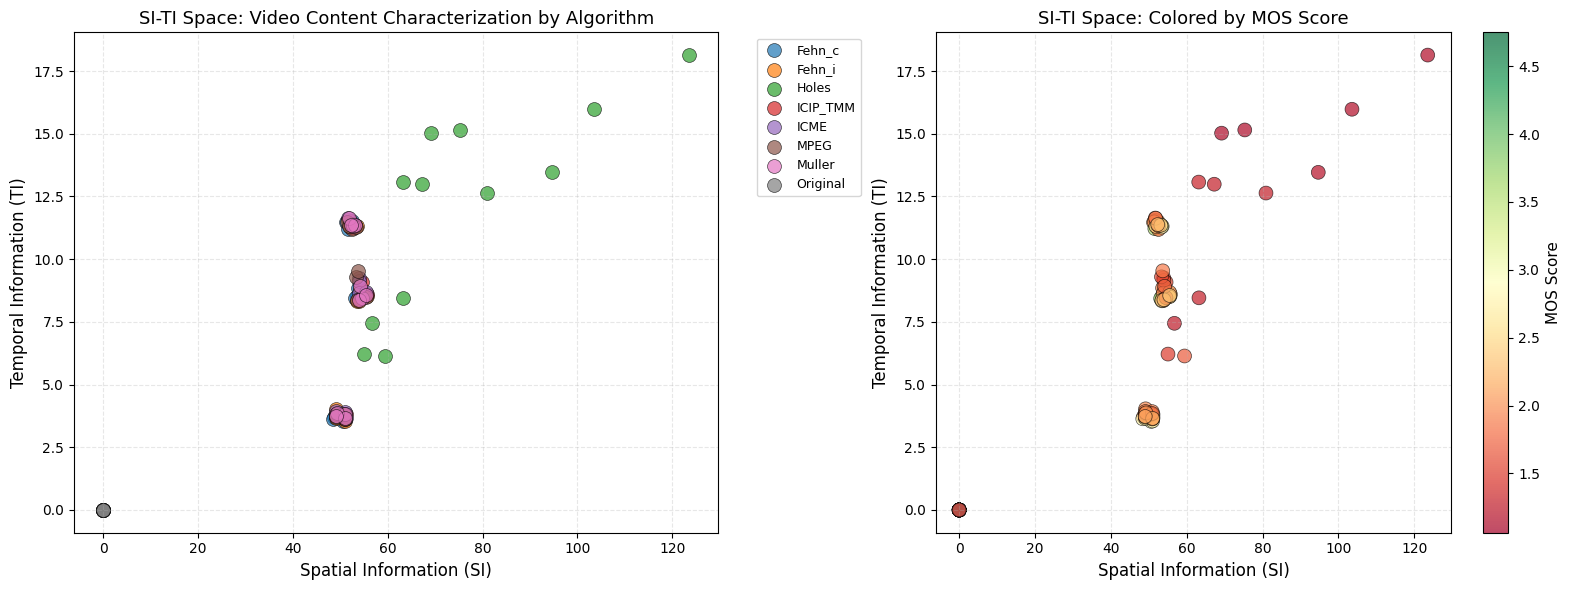


Interpretation:
- Each point represents one video
- High SI = spatially complex content (detailed scenes)
- High TI = high motion content
- Colors in right plot show if high SI/TI correlates with lower/higher MOS


In [10]:
# Visualization 1: SI/TI scatter plot colored by algorithm
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: SI/TI space
for algo in sorted(df_videos['Algo'].unique()):
    subset = df_videos[df_videos['Algo'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')

# Plot 2: SI/TI colored by MOS
scatter = axes[1].scatter(df_videos['SI_mean'], df_videos['TI_mean'], 
                         c=df_videos['MOS'], cmap='RdYlGn', 
                         s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Colored by MOS Score', fontsize=13)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('MOS Score', fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each point represents one video")
print("- High SI = spatially complex content (detailed scenes)")
print("- High TI = high motion content")
print("- Colors in right plot show if high SI/TI correlates with lower/higher MOS")